In [1]:
# https://www.mapsforeurope.org/access-data

In [2]:
import json
import os
import subprocess
import zipfile

import numpy as np

import requests

import pyproj as ppj
import rasterio

from PIL import Image

import matplotlib.pyplot as plt

from tqdm import tqdm

## Import GeoTIFF data

In [3]:
folder = "../data/eurodem/"
path = folder + "eurodem.tif"

In [4]:
with rasterio.open(path) as dataset:
    pass

In [5]:
dataset.crs

CRS.from_wkt('GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["Arcsecond",4.84813681109536E-06],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

In [6]:
# Choose location
latitude, longitude = 44.6675, 7.091667
radius = 10000

In [7]:
from rasterio.warp import transform

[cy], [cx] = transform(
    src_crs={'init': 'EPSG:4326'}, 
    dst_crs=dataset.crs, 
    xs=[latitude], 
    ys=[longitude]
)
cx, cy

(25530.0012, 160802.99999999997)

In [8]:
from shapely.geometry import Point
from shapely.ops import transform

projection = ppj.CRS.from_proj4(f"+proj=aeqd +lat_0={latitude} +lon_0={longitude} +x_0=0 +y_0=0")
transformer = ppj.Transformer.from_proj(projection, dataset.crs, always_xy=True)
buffer = Point(0, 0).buffer(radius)
coordinates = np.array(transform(transformer.transform, buffer).exterior.coords)

bounds = rasterio.coords.BoundingBox(
    left=coordinates[:, 0].min(),
    bottom=coordinates[:, 1].min(),
    right=coordinates[:, 0].max(),
    top=coordinates[:, 1].max(),
)
bounds

BoundingBox(left=25076.038034194124, bottom=160479.03874858527, right=25983.964365805878, top=161126.95612557148)

In [9]:
assert bounds.left < dataset.bounds.right and bounds.right > dataset.bounds.left
assert bounds.bottom < dataset.bounds.top and bounds.top > dataset.bounds.bottom

In [10]:
window = rasterio.windows.from_bounds(*bounds, transform=dataset.transform)
window

Window(col_off=64230.94457029698, row_off=50818.44554701437, width=453.9631658058788, height=323.958688493105)

In [11]:
with rasterio.open(path) as dataset:
    heightmap = dataset.read(1, window=window)[::-1]

In [12]:
heightmap.shape

(323, 453)

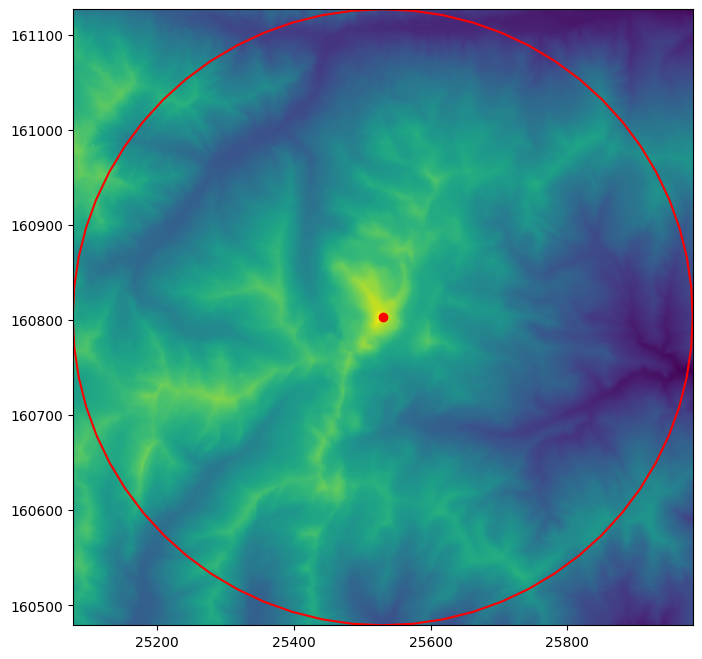

In [13]:
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(heightmap, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
ax.scatter([cx], [cy], c="r")
#q = np.linspace(0.0, 2 * np.pi, 200, endpoint=True)
ax.plot(coordinates[:, 0], coordinates[:, 1], c="r")
ax.set_aspect("auto")
plt.show()

In [14]:
radius * 2 / heightmap.shape[0], radius * 2 / heightmap.shape[1]

(61.919504643962846, 44.150110375275936)

## Generate 3D mesh

In [15]:
z_min = np.nanmin(heightmap)
z_max = np.nanmax(heightmap)
z_min, z_max

(796, 3836)

In [16]:
z_step = 20.0
z_base = z_min - z_step * 10

In [17]:
h, w = heightmap.shape

vertices = []

for i in range(h):
    for j in range(w):
        vertices.append([j, h - i - 1, (heightmap[i, j] - z_base)])

perimeter = []
for i in range(h - 1):
    perimeter.append([0, i])
for j in range(w - 1):
    perimeter.append([j, h - 1])
for i in range(h - 1, 0, -1):
    perimeter.append([w - 1, i])
for j in range(w - 1, 0, -1):
    perimeter.append([j, 0])

perimeter = perimeter[::-1]

for j, i in perimeter:
    vertices.append([j, h - i - 1, 0.0])

vertices.append([w / 2, h / 2, 0.0])

vertices = np.array(vertices)

faces = []

for i in range(h - 1):
    for j in range(w - 1):
        faces.append([i * w + j, i * w + j + 1, (i + 1) * w + j])
        faces.append([i * w + j + 1, (i + 1) * w + j + 1, (i + 1) * w + j])

for k0 in range(len(perimeter)):
    k1 = (k0 + 1) % len(perimeter)
    j0, i0 = perimeter[k0]
    j1, i1 = perimeter[k1]
    faces.append([i1 * w + j1, i0 * w + j0, h * w + k0])
    faces.append([h * w + k1, i1 * w + j1, h * w + k0])
    faces.append([h * w + len(perimeter), h * w + k1, h * w + k0])

faces = np.array(faces)

In [18]:
transform = rasterio.windows.transform(window, dataset.transform)
transform

Affine(2.0, 0.0, 25076.03803419412,
       0.0, -2.0, 161126.95612557148)

In [19]:
matrix = np.asarray(transform).reshape(3, 3)
A = matrix[:2, :2]
b = matrix[:2, 2]
vertices[:, :2] = vertices[:, :2] @ A.T + b

In [20]:
transformer = ppj.Transformer.from_crs(
    ppj.CRS.from_wkt(dataset.crs.to_wkt()),
    ppj.CRS.from_epsg(32632),
    always_xy=True,
)

In [21]:
vertices[:, 0], vertices[:, 1] = transformer.transform(vertices[:, 0], vertices[:, 1])

In [22]:
vertices[:, 0] -= vertices[:, 0].mean()
vertices[:, 1] -= vertices[:, 1].mean()

In [23]:
scale = 0.01
vertices *= scale

In [24]:
import trimesh

In [25]:
mesh = trimesh.Trimesh(vertices, faces)

In [26]:
mesh.is_watertight

True

In [27]:
mesh.is_winding_consistent

True

In [28]:
mesh.export("mesh.stl");